In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
from deeplift.dinuc_shuffle import dinuc_shuffle
import json
import os
import gzip
from math import log
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [3]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("data/models/a549_max_model.h5")







Instructions for updating:
Use `tf.cast` instead.


In [4]:
max_A_NNNN_seqToDdG = {}
max_B_NNNN_seqToDdG = {}

In [5]:
!head data/experimental/MAX_A_ddGs.csv

﻿Sequence,# substitutions,Predicted ddG,Actual ddG
GGGG,4,5.49597842,2.580144682
GGAG,3,4.413478609,2.964482398
GCGG,3,3.354832412,2.817935066
GAGG,4,4.646043518,2.865979624
GAAG,3,3.563543707,2.84468115
GTGG,4,6.067949087,2.724098983
GTAG,3,4.985449276,2.834404587
GGGC,3,3.533877546,2.099823484
GGAC,2,2.451377735,2.479258401


In [6]:
!head data/experimental/MAX_B_ddGs.csv

﻿Sequence,# substitutions,Predicted ddG,Actual ddG
GGGG,4,5.187886985,2.333524597
GGAG,3,4.21450235,2.772085496
GCGG,3,3.102691958,2.677317369
GAGG,4,4.305024253,2.688928741
GAAG,3,3.331639618,2.708786388
GTGG,4,5.569816415,2.60079957
GTAG,3,4.59643178,2.810892451
GGGC,3,3.298958775,1.963113122
GGAC,2,2.32557414,2.314668392


In [7]:
firstLine = True
with open("data/experimental/MAX_A_ddGs.csv", encoding='utf-8-sig') as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        max_A_NNNN_seqToDdG[line.strip().split(',')[0]+"GTGN"] = float(line.strip().split(',')[-1])

In [8]:
firstLine = True
with open("data/experimental/MAX_B_ddGs.csv", encoding='utf-8-sig') as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        max_B_NNNN_seqToDdG[line.strip().split(',')[0]+"GTGN"] = float(line.strip().split(',')[-1])

In [9]:
fastapath = "data/genome/male.hg19.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

seq_len = 1346
out_pred_len = 1000
test_chrms = ["chr1", "chr8", "chr21"]
seq_peaks = []
with gzip.open("data/a549_max/a549_max.bed.gz", 'rt') as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + int(line.strip().split('\t')[-1])
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        seq_peaks.append(GenomeDict[chrm][start:end].upper())
    
ltrdict = {
           'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

In [10]:
def fill_into_center(seq, insert):
    flank = int((len(seq)-len(insert))/2.0)
    new_seq = seq[:flank]
    for nuc_id, nuc in enumerate(insert):
        if nuc == 'N':
            new_seq += seq[flank+nuc_id]
        else:
            new_seq += nuc
    new_seq += seq[flank+len(insert):]
    return new_seq

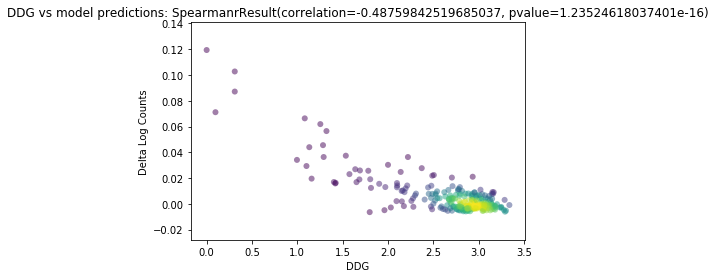

In [13]:
from deeplift.dinuc_shuffle import dinuc_shuffle

num_samples = 100
xvals = []
yvals = []
for flank in max_A_NNNN_seqToDdG:
    pre_seqs = []
    post_seqs = []
    indices = np.random.choice(len(seq_peaks), num_samples, replace=False)
    for idx in indices:
        pre_seq = dinuc_shuffle(seq_peaks[idx])
        post_seq = fill_into_center(pre_seq, flank)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    yvals.append(np.mean(post[0]-pre[0]))
    xvals.append(max_A_NNNN_seqToDdG[flank])
    
xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("DDG")
plt.ylabel("Delta Log Counts")
plt.title("DDG vs model predictions: "+str(spearmanr(xvals, yvals)))
plt.show()

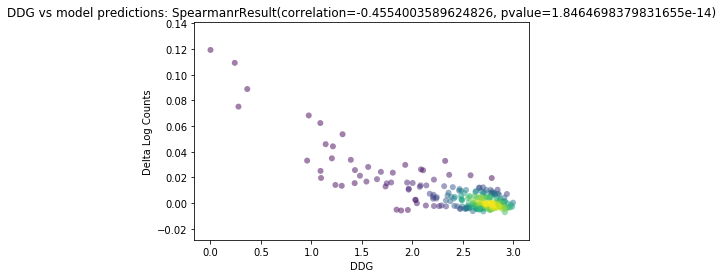

In [14]:
num_samples = 100
xvals = []
yvals = []
for flank in max_B_NNNN_seqToDdG:
    pre_seqs = []
    post_seqs = []
    indices = np.random.choice(len(seq_peaks), num_samples, replace=False)
    for idx in indices:
        pre_seq = dinuc_shuffle(seq_peaks[idx])
        post_seq = fill_into_center(pre_seq, flank)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    yvals.append(np.mean(post[0]-pre[0]))
    xvals.append(max_B_NNNN_seqToDdG[flank])
    
xy = np.vstack([xvals,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("DDG")
plt.ylabel("Delta Log Counts")
plt.title("DDG vs model predictions: "+str(spearmanr(xvals, yvals)))
plt.show()